In [ ]:
#cana_lotes.shp      ← geometria (formas dos lotes)
#cana_lotes.shx      ← índice da geometria
#cana_lotes.dbf      ← atributos (como nome do lote, área, cultura, etc.)
#cana_lotes.prj      ← sistema de projeção (como WGS84, UTM, etc.)


In [ ]:
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geemap
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ee.Authenticate()
ee.Initialize(project='smart-oasis-466614-s5')

In [ ]:
#instalando rasteri

#biblioteca Python que fornece uma maneira eficiente de ler, escrever e manipular dados raster (como imagens de satélite ou modelos digitais de elevação)
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 102.3 MB/s eta 0:00:00


In [ ]:
path_aoi_soja = '/content/drive/MyDrive/Geoscience/AOI_cana/cana_lotes.shp'

In [ ]:
gdf_soja = gpd.read_file(path_aoi_soja)

In [ ]:
gdf_soja

id                                           geometry
0 NaN  POLYGON ((-47.93468 -21.13461, -47.9334 -21.13...
1 NaN  POLYGON ((-47.93154 -21.13705, -47.92954 -21.1...
2 NaN  POLYGON ((-47.9231 -21.13705, -47.92215 -21.13...
3 NaN  POLYGON ((-47.93712 -21.13007, -47.93579 -21.1...
4 NaN  POLYGON ((-47.94116 -21.12812, -47.94111 -21.1...
5 NaN  POLYGON ((-47.92352 -21.14178, -47.92319 -21.1...

<Axes: >

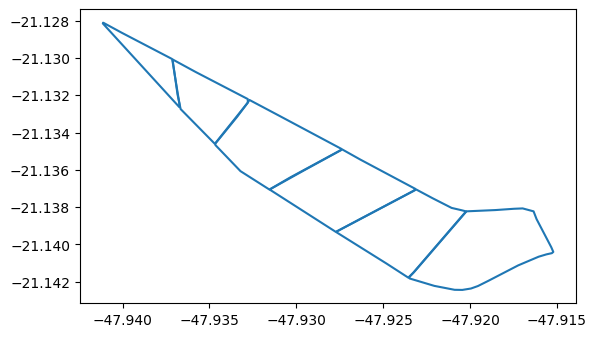

In [ ]:
#Printando o grafico dos shp
gdf_soja.boundary.plot()

In [ ]:
# 1. Importa a biblioteca geemap, que integra o Google Earth Engine (EE) com ferramentas do Python
import geemap

# 2. Supondo que já temos um GeoDataFrame (gdf_soja), geralmente carregado de um shapefile (.shp) com geopandas
#    Esse GeoDataFrame contém a geometria (coordenadas) dos lotes de soja, com atributos como nome, área, etc.

# 3. Converte o GeoDataFrame do geopandas (que roda localmente) para uma FeatureCollection do Earth Engine (que roda na nuvem)
fc = geemap.geopandas_to_ee(gdf_soja)

# Resultado:
# A variável 'fc' agora é uma ee.FeatureCollection — ou seja, um conjunto de feições geográficas que o Google Earth Engine consegue entender e processar.
# Você pode usar essa coleção para análises remotas como calcular NDVI, mascarar nuvens, recortar imagens de satélite pela área, entre outros.


In [ ]:
fc

Vamos pegar uma coleção de imagens do Sentinel 2 de 2017 até 2024

In [ ]:
S2_coll = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)).filterDate('2017-01-01','2024-12-31').filterBounds(fc)

In [ ]:
print('Total number of images', S2_coll.size().getInfo())

Total number of images 162


In [ ]:
!mkdir sentinel_2_by_year

In [ ]:
def create_image_collection_by_year(image_collection, fc, start_year, end_year):
  years = ee.List.sequence(start_year, end_year)

  def create_yearly_composite(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    year_image = image_collection \
        .filterDate(start_date, end_date) \
        .reduce(ee.Reducer.median()) \
        .set({'year': year})

    return year_image.clip(fc)

  yearly_composites = ee.ImageCollection.fromImages(
      years.map(create_yearly_composite))

  return yearly_composites


In [ ]:
#vamos aplicar coleção de imgens
start_year = 2019
end_year = 2023

yearly_s2_collection = create_image_collection_by_year(S2_coll, fc, start_year, end_year)
print(yearly_s2_collection.size().getInfo())

5


In [ ]:
Map = geemap.Map()
Map.centerObject(fc)

# Function to display an image on the map
def display_image(image):
  vis_params = {
      'bands': ['B4_median', 'B3_median', 'B2_median'],
      'min': 0,
      'max': 3000,
      'gamma': 1.4
  }
  Map.addLayer(image, vis_params, str(image.get('year').getInfo()))

# Iterate through the yearly image collection and display each image
for i in range(yearly_s2_collection.size().getInfo()):
    image = ee.Image(yearly_s2_collection.toList(yearly_s2_collection.size()).get(i))
    display_image(image)


Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
start_year = 2019
end_year = 2023

In [ ]:
#Podemos tentar exportar essas iamgnes
geemap.ee_export_image_collection(
    yearly_s2_collection,
    out_dir ='/content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year',
    scale = 20,
    crs = 'EPSG:4326',
    region = fc.geometry(),
    filenames = yearly_s2_collection.aggregate_array('year').getInfo(),
    file_per_band = False,
    timeout = 300,
    proxies = None
)

Total number of images: 5

Exporting 1/5: /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2019.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2019.tif


Exporting 2/5: /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2020.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2020.tif


Exporting 3/5: /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2021.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2021.tif


Exporting 4/5: /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2022.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2022.tif


Exporting 5/5: /content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/2023.tif

In [ ]:
!pip install rasterio
"""
 ler, escrever, manipular e analisar arquivos raster, especialmente
 no contexto de dados geoespaciais (como imagens de satélite, mapas de uso do solo, elevação etc.).

 Exemplos de uso:
Processar imagens de satélite.

Analisar NDVI (vegetação) ou outras bandas espectrais.

Recortar uma área de interesse (AOI).

Criar mapas temáticos a partir de dados de elevação ou uso do solo.
"""

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os
image_dir = './sentinel_2_by_year'
for filename in os.listdir(image_dir):
  if filename.endswith('.tif'):
    filepath = os.path.join(image_dir, filename)#Constrói um caminho de arquivo completo (filepath) combinando o diretório (image_dir) com o nome do arquivo (filename), de forma segura e compatível com qualquer sistema operaciona
    with rasterio.open(filepath) as src: #With garante que os recursos sejam abertos e fechados corretamente, mesmo que ocorra um erro
      R = src.read(4) #Banda 4 (red)
      G = src.read(3) #Banda 3 (Green)
      B = src.read(2) #Banda 2 (Blue)
      rgb = np.dstack((R,G,B))
      rgb = (rgb /4000)
      plt.figure(figsize=(10,10))
      plt.imshow(rgb)
      plt.title(filename)
      plt.axis('off')
      plt.show()



<Axes: >

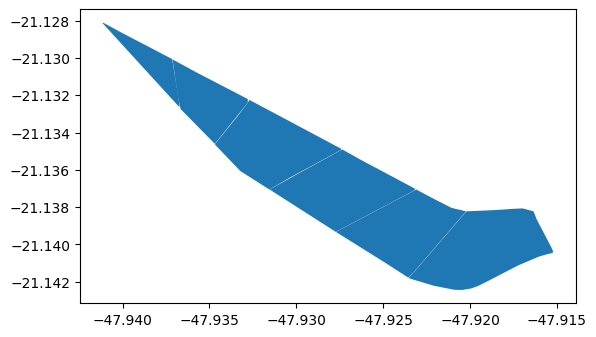

In [ ]:
gdf_soja.plot()

Extraindo informações do poligono e das imagens

In [ ]:
import json
import rasterio
from rasterio.mask import mask
total_gdf = gdf_soja.dissolve()

In [ ]:
ndvi_data = []
for year in range(start_year, end_year + 1):
  src_img = rasterio.open(f'/content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/{year}.tif')
  for feat in json.loads(total_gdf.to_json())['features']:
    out_img, _ = mask(dataset=src_img, shapes=[feat['geometry']], crop=True, nodata=-9999)

    nir = out_img[8, :, :]
    red = out_img[4, :, :]

    #Calculate NDVI, handling potential division by zero
    ndvi = np.where(red != 0, (nir - red) / (nir + red), np.nan)

    # Exclude nodata values (-9999) and NaN values when calculating mean
    valid_pixels = ndvi[ndvi != -9999]
    valid_pixels = valid_pixels[~np.isnan(valid_pixels)]
    mean_ndvi = np.nanmean(valid_pixels)

    print(f"Mean NDVI for year {year}: {mean_ndvi}")
    ndvi_data.append({'year': year, 'mean_ndvi': mean_ndvi})
ndvi_df = pd.DataFrame(ndvi_data)

Mean NDVI for year 2019: 0.11235534825508786
Mean NDVI for year 2020: 0.12091211683305336
Mean NDVI for year 2021: 0.10815726939512024


Mean NDVI for year 2022: 0.09125206936978875
Mean NDVI for year 2023: 0.10601139752554287


In [ ]:
ndvi_df

year  mean_ndvi
0  2019   0.112355
1  2020   0.120912
2  2021   0.108157
3  2022   0.091252
4  2023   0.106011

Tambem conseguimos pegar a informação gerada pelo ano e pelo poligono

In [ ]:
ndvi_by_polygon = []
for year in range(start_year, end_year + 1):
  src_img = rasterio.open(f'/content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/{year}.tif')
  for feat in json.loads(gdf_soja.to_json())['features']:
    out_img, _ = mask(dataset=src_img, shapes=[feat['geometry']], crop=True, nodata=-9999)

    nir = out_img[8, :, :]
    red = out_img[4, :, :]

    #Calculate NDVI, handling potential division by zero
    ndvi = np.where(red != 0, (nir - red) / (nir + red), np.nan)

    # Exclude nodata values (-9999) and NaN values when calculating mean
    valid_pixels = ndvi[ndvi != -9999]
    valid_pixels = valid_pixels[~np.isnan(valid_pixels)]
    mean_ndvi = np.nanmean(valid_pixels)
    ndvi_by_polygon.append({'year': year, 'mean_ndvi': mean_ndvi, 'id_polygon': feat['id']})
ndvi_polygon_df = pd.DataFrame(ndvi_by_polygon)

In [ ]:
ndvi_polygon_df

year  mean_ndvi id_polygon
0   2019   0.211833          0
1   2019   0.222753          1
2   2019   0.215872          2
3   2019   0.243543          3
4   2019   0.102792          4
5   2019   0.271991          5
6   2020   0.243169          0
7   2020   0.253338          1
8   2020   0.248999          2
9   2020   0.227691          3
10  2020   0.089343          4
11  2020   0.279476          5
12  2021   0.222637          0
13  2021   0.229863          1
14  2021   0.221499          2
15  2021   0.218580          3
16  2021   0.083739          4
17  2021   0.233424          5
18  2022   0.199790          0
19  2022   0.211180          1
20  2022   0.200020          2
21  2022   0.164285          3
22  2022   0.061607          4
23  2022   0.172599          5
24  2023   0.210022          0
25  2023   0.217239          1
26  2023   0.207668          2
27  2023   0.197545          3
28  2023   0.085981          4
29  2023   0.259470          5

Depois vamos criar varios espectros de difernetes indices e vamos obter a informação por ano e vamos plotar

In [ ]:
ndvi_ndre_ndwi_by_polygon = []
for year in range(start_year, end_year + 1):
  src_img = rasterio.open(f'/content/drive/MyDrive/Geoscience/Alvaro/Aula4/sentinel_2_by_year/{year}.tif')
  for feat in json.loads(gdf_soja.to_json())['features']:
    out_img, _ = mask(dataset=src_img, shapes=[feat['geometry']], crop=True, nodata=-9999)

    nir = out_img[8, :, :]
    red = out_img[4, :, :]
    re = out_img[5, :, :]
    green = out_img[3, :, :]

    #Calculate NDVI
    ndvi = np.where(red != 0, (nir - red) / (nir + red), np.nan)
    #Calculate NDRE
    ndre = np.where(nir != 0, (nir - re) / (nir + re), np.nan)
    #Calculate NDWI
    ndwi = np.where((green + nir) != 0, (green - nir) / (green + nir), np.nan)

    # Exclude nodata values (-9999) and NaN values when calculating mean
    valid_pixels_ndvi = ndvi[ndvi != -9999]
    valid_pixels_ndvi = valid_pixels_ndvi[~np.isnan(valid_pixels_ndvi)]
    mean_ndvi = np.nanmean(valid_pixels_ndvi)

    valid_pixels_ndre = ndre[ndre != -9999]
    valid_pixels_ndre = valid_pixels_ndre[~np.isnan(valid_pixels_ndre)]
    mean_ndre = np.nanmean(valid_pixels_ndre)

    valid_pixels_ndwi = ndwi[ndwi != -9999]
    valid_pixels_ndwi = valid_pixels_ndwi[~np.isnan(valid_pixels_ndwi)]
    mean_ndwi = np.nanmean(valid_pixels_ndwi)


    ndvi_ndre_ndwi_by_polygon.append({'year': year, 'mean_ndvi': mean_ndvi, 'mean_ndre':mean_ndre, 'mean_ndwi': mean_ndwi, 'id_polygon': feat['id']})
ndvi_ndre_ndwi_polygon_df = pd.DataFrame(ndvi_ndre_ndwi_by_polygon)

In [ ]:
ndvi_ndre_ndwi_polygon_df

year  mean_ndvi  mean_ndre  mean_ndwi id_polygon
0   2019   0.211833   0.071175  -0.292873          0
1   2019   0.222753   0.074579  -0.308874          1
2   2019   0.215872   0.071267  -0.296813          2
3   2019   0.243543   0.058453  -0.335602          3
4   2019   0.102792   0.024878  -0.147474          4
5   2019   0.271991   0.078054  -0.351619          5
6   2020   0.243169   0.056209  -0.339234          0
7   2020   0.253338   0.059032  -0.354262          1
8   2020   0.248999   0.060208  -0.341119          2
9   2020   0.227691   0.058162  -0.314856          3
10  2020   0.089343   0.025259  -0.130339          4
11  2020   0.279476   0.065116  -0.401848          5
12  2021   0.222637   0.060281  -0.320042          0
13  2021   0.229863   0.065044  -0.331048          1
14  2021   0.221499   0.058338  -0.318446          2
15  2021   0.218580   0.050339  -0.307804          3
16  2021   0.083739   0.020576  -0.121875          4
17  2021   0.233424   0.061486  -0.350738          5
18  2022   0.199790   0.056870  -0.295521          0
19  2022   0.211180   0.060725  -0.310015          1
20  2022   0.200020   0.057007  -0.290526          2
21  2022   0.164285   0.051227  -0.237701          3
22  2022   0.061607   0.021142  -0.091213          4
23  2022   0.172599   0.059635  -0.269935          5
24  2023   0.210022   0.062079  -0.296140          0
25  2023   0.217239   0.064826  -0.306923          1
26  2023   0.207668   0.061425  -0.292091          2
27  2023   0.197545   0.052667  -0.228555          3
28  2023   0.085981   0.022509  -0.108081          4
29  2023   0.259470   0.071183  -0.368327          5

## Timelapses
A geemap tambem pode criar timelapses

In [ ]:
Map = geemap.Map()
roi = Map.user_roi
if roi is None:
    roi = ee.Geometry.BBox(-18.6983, -36.1630, 52.2293, 38.1446)#Cria uma bounding box (caixa retangular) com coordenadas longitude/latitude nos eixos X/Y
    Map.addLayer(roi)
    Map.centerObject(roi)

First one using NDVI from the MODIS satellite


In [ ]:
timelapse = geemap.modis_ndvi_timelapse(
    roi,
    out_gif='ndvi.gif',
    data='Terra',
    band='NDVI',
    start_date='2000-01-01',
    end_date='2022-12-31',
    frames_per_second=3,
    title='MODIS NDVI Timelapse',
    overlay_data='countries',
)
geemap.show_image(timelapse)
"""
Essa função gera um GIF de timelapse com imagens NDVI da vegetação ao longo do tempo.
"""

Generating URL...
Please wait ...
The GIF image has been saved to: /content/ndvi.gif


Output()

In [ ]:
roi = ee.Geometry.BBox(-171.21, -57.13, 177.53, 79.99)
Map.addLayer(roi)
Map.centerObject(roi)

In [ ]:
#Podemos tambem mostrar a temperatura dos oceanos
timelapse = geemap.modis_ocean_color_timelapse(
    satellite='Aqua',
    start_date='2025-07-01',
    end_date='2020-12-31',
    roi=roi,
    frequency='month',
    out_gif='temperature.gif',
    overlay_data='continents',
    overlay_color='yellow',
    overlay_opacity=0.5,
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/temperature.gif


ModuleNotFoundError: No module named 'ffmpeg'

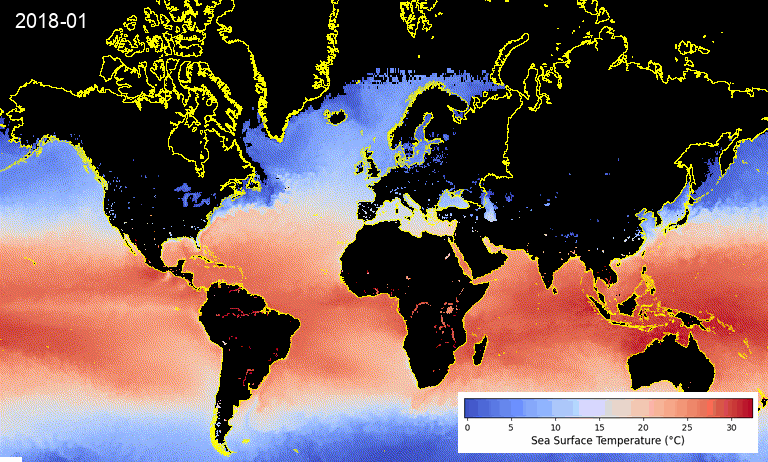

In [ ]:
from IPython.display import Image

Image(filename='temperature.gif')


In [ ]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
